In [174]:
import numpy as np
import matplotlib.pyplot as plt

In [112]:
pima = np.genfromtxt('pima-indians-diabetes.data', delimiter=',')

def sghmc(Y, X, stogradU, M, eps, m, theta, C, V):
    n = X.shape[0]
    p = X.shape[1]
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(M.shape[0]),M)[:,np.newaxis]
    
    # Precompute
    B = 0.5 * V * eps
    D = 2*(C-B)*eps
    Minv = np.linalg.inv(M)
    
    # Hamiltonian dynamics
    for i in range(m):
        theta = theta + (eps*np.linalg.inv(M) @ r).ravel()
        r = r - eps*stogradU(theta, Y, X, nbatch) - eps*C @ Minv @ r \
            + np.random.multivariate_normal(np.zeros(M.shape[0]),D)[:,np.newaxis]

    return(theta)

def stogradU(theta, Y, X, nbatch):
    '''A function that returns the stochastic gradient. Adapted from Eq. 5.
    Inputs are:
        theta, the parameters
        Y, the response
        X, the covariates
        nbatch, the number of samples to take from the full data
    '''
    alpha=5
    n = X.shape[0]
    batch_id = np.random.choice(np.arange(n),nbatch,replace=False)
    grad = -n/nbatch * X[batch_id,:].T @ (Y[batch_id][:,np.newaxis] - \
        1/(1+np.exp(-X[batch_id,:] @ theta[:,np.newaxis]))) - theta[:,np.newaxis]/alpha
    return grad

def logistic(x):
    return 1/(1+np.exp(-x))

def stogradU(theta, Y, X, nbatch):
    '''A function that returns the stochastic gradient. Adapted from Eq. 5.
    Inputs are:
        theta, the parameters
        Y, the response
        X, the covariates
        nbatch, the number of samples to take from the full data
    '''
    alpha=5
    n = X.shape[0]
    batch_id = np.random.choice(np.arange(n),nbatch,replace=False)
    
    Y_pred = logistic(X[batch_id,:] @ theta[:,np.newaxis])
    epsilon = (Y[batch_id][:,np.newaxis] - Y_pred)
    grad = -n/nbatch * X[batch_id,:].T @ epsilon - theta[:,np.newaxis]/alpha
    
    return grad/n

In [119]:
# Load data
X = np.concatenate((np.ones((pima.shape[0],1)),pima[:,0:8]), axis=1)
Y = pima[:,8]

Xs = (X - np.mean(X, axis=0))/np.concatenate((np.ones(1),np.std(X[:,1:], axis=0)))
n, p = X.shape

nsample = 1
nbatch = 768
M = np.identity(p)
C = 0 * np.identity(p)
eps = 0.1
m = 10
V = 0 * np.identity(p)
theta = np.zeros(p)

In [590]:
### HMC version
def logistic(x):
    return 1/(1+np.exp(-x))

def U(theta, Y, X):
    return - (Y.T @ X @ theta - np.sum(np.log(1+np.exp(X @ theta))))

def gradU(theta, Y, X, nbatch):
    '''A function that returns the stochastic gradient. Adapted from Eq. 5.
    Inputs are:
        theta, the parameters
        Y, the response
        X, the covariates
        nbatch, the number of samples to take from the full data
    '''
    n = X.shape[0]
    
    Y_pred = logistic(X @ theta)
    epsilon = (Y[:,np.newaxis] - Y_pred[:,np.newaxis])
    grad = X.T @ epsilon

    return -grad/n
    #temp = -grad/n
    #return temp / np.linalg.norm(temp)


def hmc(Y, X, gradU, M, eps, m, theta, C, V):
    theta0 = theta.copy()
    
    # This is just HMC for testing
    n = X.shape[0]
    p = X.shape[1]
    
    # Precompute
    Minv = np.linalg.inv(M)
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Intial energy
    H0 = U(theta, Y, X) + 0.5 * np.asscalar(r.T @ Minv @ r)
    
    # Hamiltonian dynamics
    r = r - (eps/2)*gradU(theta, Y, X, nbatch)
    for i in range(m):
        theta = theta + (eps*Minv@r).ravel()
        r = r - eps*gradU(theta, Y, X, nbatch)
    theta = theta + (eps*Minv@r).ravel()
    r = r - (eps/2)*gradU(theta, Y, X, nbatch)  
    
    # Final energy
    H1 = U(theta, Y, X) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    # MH step
    u = np.random.uniform()
    #rho = np.exp(H1 - H0)
    rho = np.exp(H0 - H1)
    #print('(H0, H1, rho): %s,%s,%s' % (H0, H1, rho))
    
    if u < np.min((1, rho)):
        return theta.copy()
    else:
        return theta0.copy() # reject
        
        
    return theta

def my_gd(Y, X, gradU, M, eps, m, theta, C, V):
    # gradient descent
    n = X.shape[0]
    p = X.shape[1]
    
    for i in range(m):
        theta = theta - eps*gradU(theta, Y, X, nbatch).ravel()
        
    return theta

### Correct coefficients

In [254]:
from sklearn.linear_model import LogisticRegression

In [457]:
# Unscaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(X,Y)
beta_true_unscale = mod_logis.coef_.ravel()
beta_true_unscale

array([ -8.31498612e+00,   1.22560027e-01,   3.49183220e-02,
        -1.34118967e-02,   6.28219471e-04,  -1.17179659e-03,
         8.86606033e-02,   9.30419443e-01,   1.46781178e-02])

In [458]:
# Scaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(Xs,Y)
beta_true_scale = mod_logis.coef_.ravel()
beta_true_scale

array([ 0.        ,  0.39024907,  1.08791914, -0.24544979,  0.02250608,
       -0.1621995 ,  0.59035938,  0.32483104,  0.12120845])

In [507]:
U(np.ones(p)*.1,Y,X)

16642.096817683432

In [508]:
gradU(np.ones(p)*.1, Y, X, 1)*n

array([[   499.99988232],
       [  1648.99976291],
       [ 54989.99137731],
       [ 34091.9995767 ],
       [  9831.99982455],
       [ 34395.99999878],
       [ 15152.09962158],
       [   214.86697893],
       [ 15594.99738417]])

### Our code - HMC

In [677]:
# HMC - Unscaled
nsample = 10000
m = 20
eps = .0001
theta = np.zeros(p)
#theta = beta_true_unscale.copy()

np.random.seed(2)
samples = np.zeros((nsample, p))
u = np.zeros(nsample)
for i in range(nsample):
    theta = hmc(Y, X, gradU, M, eps, m, theta, C, V)
    samples[i] = theta
    u[i] = U(theta, Y, X)
    
np.mean(samples, axis=0) - beta_true_unscale

array([  8.29486852e+00,  -4.63105686e-02,  -2.15053072e-02,
        -1.66602647e-02,  -1.06837083e-04,   1.86101570e-03,
        -9.23812259e-02,  -9.27538689e-01,  -2.25760469e-02])

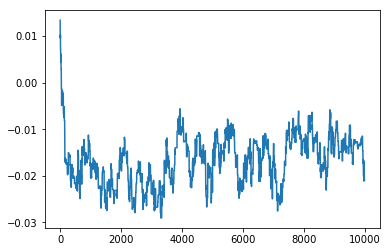

In [681]:
plt.plot((samples - beta_true_unscale)[:,3])
plt.show()

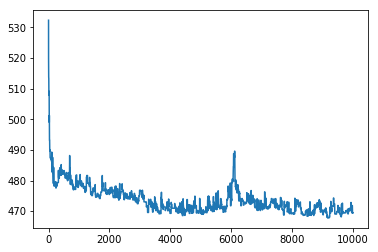

In [683]:
plt.plot(u)
plt.show()

In [668]:
# HMC - Scaled
nsample = 10000
m = 20
eps = .001
theta = np.zeros(p)
#theta = beta_true_scale.copy()

np.random.seed(2)
samples = np.zeros((nsample, p))
u = np.zeros(nsample)
for i in range(nsample):
    theta = hmc(Y, Xs, gradU, M, eps, m, theta, C, V)
    samples[i] = theta
    u[i] = U(theta, Y, Xs)
    
np.mean(samples, axis=0) - beta_true_scale

array([ 1.62428113, -0.00560003,  0.00625545,  0.01065339,  0.00263785,
       -0.01313617, -0.00682813,  0.00379025, -0.01856026])

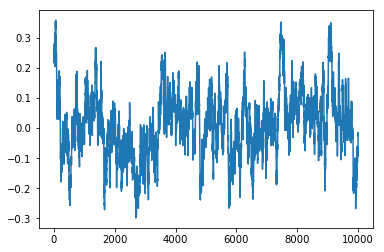

In [669]:
plt.plot((samples - beta_true_scale)[:,3])
plt.show()

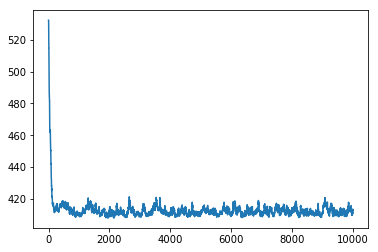

In [670]:
plt.plot(u)
plt.show()

In [673]:
# HMC - Scaled (no intercept)
nsample = 1000
m = 20
eps = .001
theta = np.zeros(p-1)
#theta = beta_true_scale.copy()[1:]

np.random.seed(2)
samples = np.zeros((nsample, p-1))
u = np.zeros(nsample)
for i in range(nsample):
    theta = hmc(Y, Xs[:,1:], gradU, np.identity(p-1), eps, m, theta, C, V)
    samples[i] = theta
    u[i] = U(theta, Y, Xs[:,1:])
    
np.mean(samples, axis=0) - beta_true_scale[1:]

array([-0.01600709, -0.15053874,  0.07410716, -0.10855771,  0.16989274,
       -0.07740612, -0.08175493, -0.07239954])

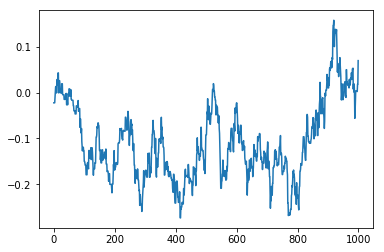

In [675]:
plt.plot((samples - beta_true_scale[1:])[:,3])
plt.show()

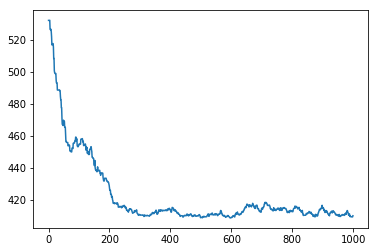

In [676]:
plt.plot(u)
plt.show()

### Our code - Gradient descent

In [324]:
# Gradient descent - Unscaled
np.random.seed(2)
#res = my_gd(Y, X, gradU, M, .0001, 10000, np.zeros(p), C, V) # Starting at zero
#res = my_gd(Y, X, gradU, M, .0001, 10000, beta_true_unscale.copy(), C, V) # Starting at true values

res = my_gd(Y, X, gradU, M, .0001, 10000, beta_true_unscale.copy(), C, V) # Starting at true values

res - beta_true_unscale

array([ -2.19413632e-04,   2.36331548e-04,   7.48727924e-06,
         2.31994484e-06,   9.33934233e-06,  -3.92206222e-07,
        -2.15577090e-05,   1.00758322e-04,  -4.00087824e-05])

In [325]:
# Gradient descent - Scaled
np.random.seed(2)
res = my_gd(Y, Xs, gradU, M, .1, 20000, np.zeros(p), C, V)

res - beta_true_scale

array([  0.00000000e+00,   4.17596046e-06,   5.92833240e-06,
         3.17764100e-06,   8.84196257e-06,  -2.98662348e-06,
        -1.76233441e-05,   8.02028628e-06,  -7.35280641e-06])

### Cliburn's code

In [12]:
# Cliburn's gradient descent code

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

In [13]:
# Unscaled
#res = gd(X, Y.ravel(), np.zeros(p), alpha=.1, niter=2) # Starting at zero
res = gd(X, Y.ravel(), beta_true_unscale.copy(), alpha=.0001, niter=10000) # Starting at true coefficients

res - beta_true_unscale

array([ -2.19413632e-04,   2.36331548e-04,   7.48727924e-06,
         2.31994484e-06,   9.33934233e-06,  -3.92206222e-07,
        -2.15577090e-05,   1.00758322e-04,  -4.00087824e-05])

In [14]:
# Scaled
res = gd(Xs, Y.ravel(), np.zeros(p), alpha=.1, niter=20000)

res - beta_true_scale

array([  0.00000000e+00,   4.17596046e-06,   5.92833240e-06,
         3.17764100e-06,   8.84196257e-06,  -2.98662348e-06,
        -1.76233441e-05,   8.02028628e-06,  -7.35280641e-06])